In [1]:
from dataclasses import dataclass
from functools import partial

import gym
import numpy as np
from tqdm.auto import tqdm

/home/rabadaba/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass(frozen=True)
class ExplorationConfig:
    exploration_rate: float
    max_epsilon: float
    min_epsilon: float
    rate: float


@dataclass(frozen=True)
class Config:
    num_episodes: int
    learning_rate: float
    discount_factor: float
    exploration: ExplorationConfig

In [3]:
class QLearningAgent:
    def __init__(self, config: Config):
        self.env_factory = partial(
            gym.make,
            "FrozenLake-v1",
            desc=None,
            map_name="8x8",
            is_slippery=False,
            max_episode_steps=15,
        )
        self.env = self.env_factory()
        self.q_table = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.config = config
        self.exploration_rate = self.config.exploration.exploration_rate

    def policy(self, state):
        if np.random.rand() > self.exploration_rate:
            return np.argmax(self.q_table[state])
        else:
            return self.env.action_space.sample()

    def update_q_table(self, state, action, reward, next_state):
        self.q_table[state, action] += self.config.learning_rate * (
            reward
            + self.config.discount_factor * np.max(self.q_table[next_state])
            - self.q_table[state, action]
        )
        
    def calculate_exploration_rate(self, episode_idx):
        return self.config.exploration.min_epsilon + (
            self.config.exploration.max_epsilon
            - self.config.exploration.min_epsilon
        ) * np.exp(-self.config.exploration.rate * episode_idx)

    @staticmethod
    def claculate_reward(env_reward, fell_into_lake, took_a_turn) -> int:
        env_reward += 10 if env_reward == 1 else 0  # Reward for reaching the goal
        env_reward -= 0.01  # Penalize each step to encourage shorter paths
        env_reward -= 1 if fell_into_lake else 0 # Penalize falling into a hole
        env_reward -= 0.01 if took_a_turn else 0 # Penalize changing direction
        return env_reward

    def train(self):
        state, _ = self.env.reset(seed=42)
        episode_rewards = []
        actions_checkpoints = []
        previous_action = None
        for episode_idx in tqdm(
            range(self.config.num_episodes), total=self.config.num_episodes
        ):
            cumulative_reward = 0
            while True:
                action = self.policy(state)
                next_state, env_reward, terminated, truncated, _ = self.env.step(action)
                reward = self.claculate_reward(env_reward, terminated and next_state != self.env.action_space.n, previous_action != action)
                self.update_q_table(state, action, reward, next_state)
                
                previous_action = action
                cumulative_reward += reward
                state = next_state
                
                if terminated or truncated:
                    break

            episode_rewards.append(cumulative_reward)

            if (
                (episode_idx + 1) % int(self.config.num_episodes / 2) == 0
            ):
                print(f"Episode {episode_idx + 1} - Reward: {cumulative_reward}")
                actions_checkpoints.append(self.test())

            self.exploration_rate = self.calculate_exploration_rate(episode_idx)

            state, _ = self.env.reset()

        self.env.close()
        return episode_rewards, actions_checkpoints

    def test(self) -> list[int]:
        state, _ = self.env.reset(seed=42)
        current_epsilon = self.exploration_rate
        self.exploration_rate = 0
        actions = []

        while True:
            action = self.policy(state)
            actions.append(action)
            next_state, _, terminated, truncated, _ = self.env.step(action)
            state = next_state
            if terminated or truncated:
                break
        self.env.close()
        self.exploration_rate = current_epsilon
        return actions

    def render_signle_episode(self, actions: list[int]):
        env = self.env_factory(render_mode="human")
        env.reset(seed=42)
        env.render()
        for action in actions:
            env.step(action)
        env.close()

    def render_multiple_episodes(self, actions: list[list[int]]):
        for action in actions:
            self.render_signle_episode(action)

In [4]:
agent = QLearningAgent(
    Config(
        num_episodes=10000,
        learning_rate=0.9,
        discount_factor=0.95,
        exploration=ExplorationConfig(
            exploration_rate=1.0, max_epsilon=1.0, min_epsilon=0.01, rate=0.001
        ),
    )
)

In [6]:
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
rewards, episode_checkpoints = agent.train()

 68%|██████▊   | 6843/10000 [00:00<00:00, 11312.52it/s]

Episode 5000 - Reward: 9.84


100%|██████████| 10000/10000 [00:00<00:00, 11145.39it/s]

Episode 10000 - Reward: 9.84


In [7]:
agent.render_multiple_episodes(episode_checkpoints)

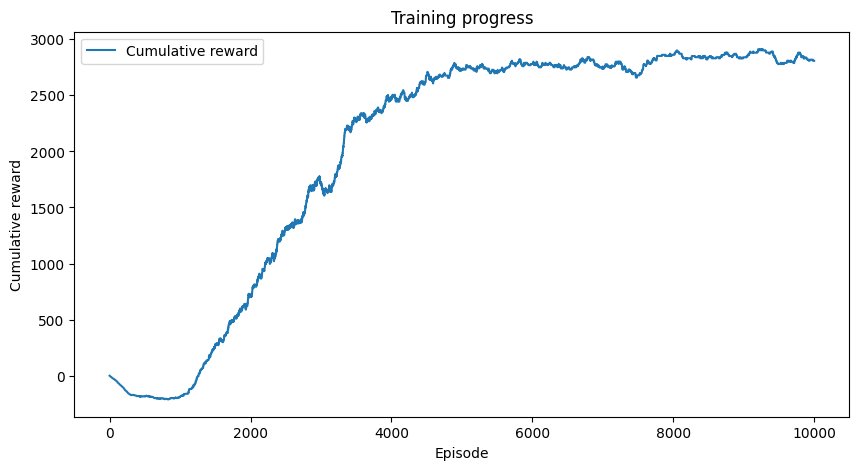

In [8]:
import matplotlib.pyplot as plt

r = np.zeros(len(rewards))
for i in range(len(rewards)):
    r[i] = sum(rewards[max(0, i - 300) : i + 1])
plt.figure(figsize=(10, 5))
plt.plot(r, label="Cumulative reward")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.title("Training progress")
plt.legend()
plt.show()

Text(0.5, 58.7222222222222, 'Action')

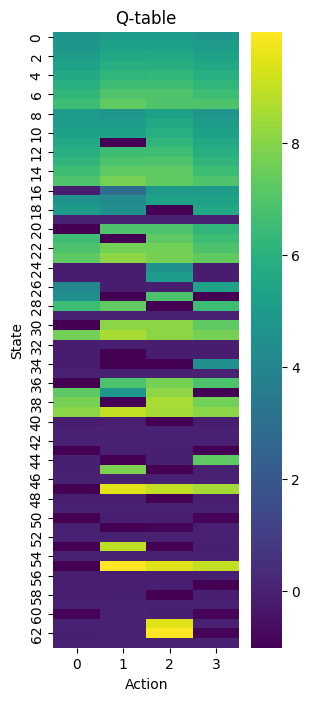

In [9]:
import seaborn as sns

plt.figure(figsize=(3, 8))
sns.heatmap(agent.q_table, cmap="viridis", annot=False)
plt.title("Q-table")
plt.ylabel("State")
plt.xlabel("Action")